In [1]:
import pandas as pd
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/flecourtier/anaconda3/envs/phifem_scimba_2/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Configure testcase
form = "Cat"
num_config = 2
nb_vert = 200

filename = form+"_lv"+str(num_config)+"_"+str(nb_vert)+"_all.csv"
filename = "masks/" + filename

In [3]:
# Read data
data = pd.read_csv(filename) #, header=None)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [4]:
class Deep2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Linear(60, 60)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Linear(60, 60)
        self.act5 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.act4(self.layer4(x))
        x = self.act5(self.layer5(x))
        x = self.sigmoid(self.output(x))
        return x

In [5]:
# Compare model sizes
model1 = Deep2()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()])) 

14881


In [6]:
import copy
import numpy as np
import torch.optim as optim
import tqdm

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epochs {epoch}: accuracy = {acc:.4f}")
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [7]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep2()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))

Epochs 0: accuracy = 0.8898
Epochs 1: accuracy = 0.9043
Epochs 2: accuracy = 0.9127
Epochs 3: accuracy = 0.9211
Epochs 4: accuracy = 0.9300
Epochs 5: accuracy = 0.9350
Epochs 6: accuracy = 0.9388
Epochs 7: accuracy = 0.9418
Epochs 8: accuracy = 0.9443
Epochs 9: accuracy = 0.9457
Epochs 10: accuracy = 0.9471
Epochs 11: accuracy = 0.9516
Epochs 12: accuracy = 0.9541
Epochs 13: accuracy = 0.9570
Epochs 14: accuracy = 0.9584
Epochs 15: accuracy = 0.9596
Epochs 16: accuracy = 0.9609
Epochs 17: accuracy = 0.9620
Epochs 18: accuracy = 0.9625
Epochs 19: accuracy = 0.9632
Epochs 20: accuracy = 0.9641
Epochs 21: accuracy = 0.9648
Epochs 22: accuracy = 0.9661
Epochs 23: accuracy = 0.9671
Epochs 24: accuracy = 0.9677
Epochs 25: accuracy = 0.9688
Epochs 26: accuracy = 0.9689
Epochs 27: accuracy = 0.9693
Epochs 28: accuracy = 0.9702
Epochs 29: accuracy = 0.9702
Epochs 30: accuracy = 0.9712
Epochs 31: accuracy = 0.9723
Epochs 32: accuracy = 0.9723
Epochs 33: accuracy = 0.9725
Epochs 34: accuracy = 0.

In [8]:
y_pred = model(X_train)
y_pred = y_pred.round()
y_pred

tensor([[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

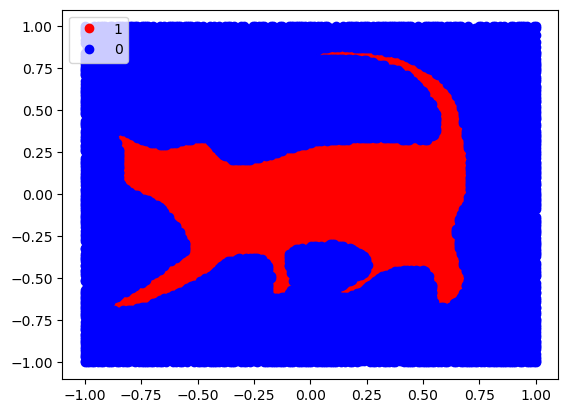

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_train[y_train[:, 0] == 1, 0], X_train[y_train[:, 0] == 1, 1], 'ro', label='1')
plt.plot(X_train[y_train[:, 0] == 0, 0], X_train[y_train[:, 0] == 0, 1], 'bo', label='0')
plt.legend()

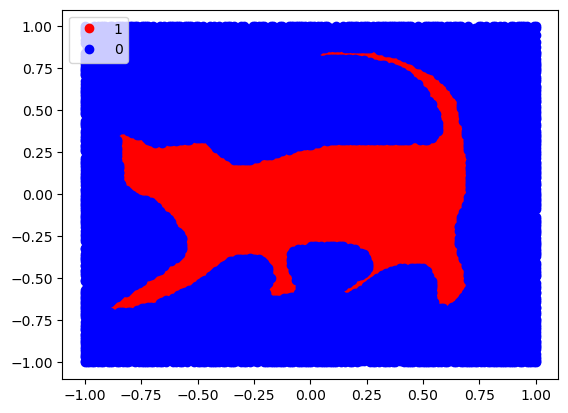

In [10]:
plt.figure()
plt.plot(X_train[y_pred[:, 0] == 1, 0], X_train[y_pred[:, 0] == 1, 1], 'ro', label='1')
plt.plot(X_train[y_pred[:, 0] == 0, 0], X_train[y_pred[:, 0] == 0, 1], 'bo', label='0')
plt.legend()

In [11]:
# save the model
torch.save(model.state_dict(), "deep2_model.pth")